In [1]:

import shutil
import gc

# synthetic data
from datetime import datetime
from PIL import Image
import os, os.path
import torchvision.transforms.functional as TF
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import torch
import math
import sys
from skimage.transform import rescale, resize, downscale_local_mean
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import numpy as np
from sklearn import model_selection
import torch.optim.lr_scheduler as Lrate
import random
from random import randrange
import fnmatch
import cv2
import openslide

In [2]:
def tils_density(input_path):
    tils_hm_files = fnmatch.filter(os.listdir(input_path+'pred_tils/'), '*LN*_gray.png')
    tils_hm_files.sort()
    
    M=17; N=17
    with open('result_Tumor_tils_density_LN.csv', 'w') as outfile :
        outfile.write('file_name,immune_infl,immune_excl,immune_des, til_tumor\n')
        for tils_file in tils_hm_files :          

            tissue_mask_file = tils_file.split('_gray')[0] + '.png'
            tumor_file = tils_file
            til = input_path + '/pred_tils/' + tils_file
            tissue_mask = input_path + '/tissue_mask/'+ tissue_mask_file
            tumor = input_path + '/pred_tumor/' + tumor_file
            stroma=input_path + '/pred_stromal/' + tils_file
            til_img = plt.imread(til)
            #plt.imshow(til_img)
            #plt.show()
            #print('til:',til_img.shape)
            R, G, B = til_img[:,:,0], til_img[:,:,1], til_img[:,:,2]
            til_img_gray=np.mean([R,G,B], axis=0)
            til_img_gray[til_img_gray >= 0.5] = 1
            til_img_gray[til_img_gray < 0.5] = 0
            tumor_img = plt.imread(tumor)
            #print('Tumor:',tumor_img.shape)
            #plt.imshow(tumor_img)
            #plt.show()
            R, G, B = tumor_img[:,:,0], tumor_img[:,:,1], tumor_img[:,:,2]
            tumor_img_gray = np.mean([R,G,B], axis=0)
            tumor_img_gray[tumor_img_gray >= 0.5] = 1
            tumor_img_gray[tumor_img_gray < 0.5] = 0
            tumor_img_gray = resize(tumor_img_gray, (til_img_gray.shape[0],til_img_gray.shape[1]))
            tissue_mask_img = plt.imread(tissue_mask)
            #print('tissue:',tissue_mask_img.shape)
            #plt.imshow( tissue_mask_img)
            #plt.show()
            tissue_mask_img = resize(tissue_mask_img, (til_img.shape[0],til_img.shape[1], 3))
            R, G, B = tissue_mask_img[:,:,0], tissue_mask_img[:,:,1], tissue_mask_img[:,:,2]
            tissue_mask_img_gray = np.mean([R,G,B], axis=0)
            tissue_mask_img_gray[tissue_mask_img_gray >= 0.5] = 1
            tissue_mask_img_gray[tissue_mask_img_gray < 0.5] = 0
            tiles = [tissue_mask_img_gray[x:x+M,y:y+N] for x in range(0,tissue_mask_img_gray.shape[0],M) for y in range(0,tissue_mask_img_gray.shape[1],N)]
            #print(tiles)
            stroma_img = plt.imread(stroma)
            stroma_img = resize(stroma_img, (til_img_gray.shape[0],til_img_gray.shape[1]))
            R, G, B = stroma_img[:,:,0], stroma_img[:,:,1], stroma_img[:,:,2]
            stroma_img = np.mean([R,G,B], axis=0)
            #print('stroma:',stroma_img.shape)
            #plt.imshow(stroma_img)
            #plt.show()

            overlap_tt = til_img_gray + tumor_img_gray #overlap TIL and Tumor
            overlap_ts=til_img_gray + stroma_img
            overlap_tst=tissue_mask_img_gray + til_img_gray
            c_overlap_tt = overlap_tt > 1
            overlap_count = sum(map(lambda x : x == True, c_overlap_tt))
            sum_overlap = np.sum(overlap_count)
            c_overlap_ts=overlap_ts > 1
            c_overlap_tst=overlap_tst > 1
            imm_inf=0
            imm_excl=0
            imm_des=0
            c_tissue=0
            i=0
            for x in range(0,tissue_mask_img_gray.shape[0],M):
                for y in range(0,tissue_mask_img_gray.shape[1],N):
                    #print(i)
                    #print(tiles[i].sum())
                    if (tiles[i].sum())>100:
                        tissue_sum=tiles[i].sum()
                        c_tissue+=1 #count the number of tissue tiles
                        overlap_count_tt = sum(map(lambda x : x == True, c_overlap_tt[x:x+M,y:y+N]))
                        overlap_count_ts = sum(map(lambda x : x == True, c_overlap_ts[x:x+M,y:y+N]))
                        overlap_count_tst = sum(map(lambda x : x == True, c_overlap_tst[x:x+M,y:y+N]))
                        sum_overlap_tt = np.sum(overlap_count_tt)
                        sum_overlap_ts = np.sum(overlap_count_ts)
                        sum_overlap_tst = np.sum(overlap_count_tst)
                        #print(sum_overlap_tt/np.count_nonzero(tumor_img_gray[x:x+M,y:y+N]),sum_overlap_ts/np.count_nonzero(stroma_img[x:x+M,y:y+N]),sum_overlap_tst)
                        if np.isnan(sum_overlap_tt/np.count_nonzero(tumor_img_gray[x:x+M,y:y+N]))==False and sum_overlap_tt/np.count_nonzero(tumor_img_gray[x:x+M,y:y+N]) > 0.4:
                            imm_inf+=1
                        elif np.isnan(sum_overlap_ts/np.count_nonzero(stroma_img[x:x+M,y:y+N]))==False and sum_overlap_ts/np.count_nonzero(stroma_img[x:x+M,y:y+N]) >0.2:
                            imm_excl+=1
                        else:
                            imm_des+=1
                    i+=1
            print(tissue_mask_file.split('_')[0],imm_inf,imm_excl,c_tissue,imm_des)
            outfile.write(tissue_mask_file.split('_')[0]
                              + ',' + str(imm_inf/c_tissue)
                              + ',' + str(imm_excl/c_tissue)
                              + ',' + str(imm_des/c_tissue)+ ','+str(sum_overlap / np.count_nonzero(tumor_img_gray)) + '\n')
    outfile.close()

input_path = 'hxu_predictions-Jinhwan/'
tils_density(input_path)

1664369 86 15 101 0
2305194 65 2 70 3
2332894 39 1 43 3
2339093 16 39 105 50
2369433 77 11 91 3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in long_scalars


2747756 19 21 105 65
2991376 79 7 88 2
3024155 54 5 65 6
3107974 34 0 34 0
3432956 18 60 99 21
3537256 50 14 83 19
3824123 50 7 57 0
3850843 66 9 79 4
4109721 8 25 72 39
4216047 24 19 71 28
4216530 39 1 44 4
4311337 54 36 120 30
5072942 67 12 84 5
5104186 52 17 105 36
5279864 77 37 126 12
5286554 41 10 61 10
5333027 24 21 97 52
5402709 3 9 56 44
5428365 50 11 66 5
5499473 77 6 96 13
6037584 41 25 86 20
6087786 59 35 108 14
6413725 53 6 59 0
6440421 56 2 58 0
6448598 18 16 40 6
6660500 33 1 54 20
7003888 63 10 78 5
7007848 65 1 66 0
7013673 33 4 47 10
7041998 13 15 40 12
7049339 26 29 69 14
7064074 22 18 53 13
7085615 86 24 114 4
7098750 8 37 84 39
7134164 39 29 85 17
7139421 18 2 21 1
7139472 67 4 71 0
7143632 49 27 76 0
7146579 11 21 40 8
7153027 0 15 49 34
7187362 36 14 53 3
7199977 59 5 74 10
7200749 58 12 74 4
7206384 18 6 31 7
7232287 43 62 137 32


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in long_scalars


7244024 75 32 118 11
7253300 25 35 64 4
7311555 41 62 112 9
7330795 25 6 48 17
7335343 73 32 118 13
7358033 82 2 89 5
7362883 70 1 72 1
7415202 33 36 71 2
8361486 32 20 83 31
8411283 67 7 94 20
8731856 38 14 84 32
8937583 26 16 84 42
9022920 65 33 105 7
9073175 5 35 75 35
9101243 37 14 64 13
9127506 69 4 75 2
9135020 49 27 78 2
9168841 64 18 85 3
9244977 22 21 72 29
9961502 2 21 55 32


In [3]:
import pandas as pd
df_p=pd.read_excel(io='2022-04-19 TILs Analysis Spreadsheet.xlsx')
df_p.head()

df_a=pd.read_csv('result_Tumor_tils_density_LN.csv')
df_a.rename(columns={'file_name':'MRN'}, inplace=True)
df_a.head()



,MRN,immune_infl,immune_excl,immune_des,til_tumor
0,1664369,0.851485,0.148515,0.000000,0.591514
1,2305194,0.928571,0.028571,0.042857,0.608437
2,2332894,0.906977,0.023256,0.069767,0.738640
3,2339093,0.152381,0.371429,0.476190,0.218032
4,2369433,0.846154,0.120879,0.032967,0.525786


In [4]:
df_m=pd.merge(df_p,df_a)
df_m.columns

Index(['MRN', 'REDCap ID', 'Match ID (Used to Link Cases and Controls)',
       'Pathology Accession Number', 'Case (1=Y)',
       'Years to Progression or Last Follow-up', 'Age at Surgery in Years',
       'Male Sex (1=Y)', 'Overall ACE-27 Score', 'Pack-years >10 (1=Y)',
       'AJCC 8th Edition Pathologic Overall Stage', 'Primary Management',
       'Primary Tumor Tumoral TILs Density',
       'Primary Tumor Stromal TILs Density',
       'Primary Tumor Pattern of Invasion', 'Lymph Node Tumoral TILs Density',
       'Lymph Node Stromal TILs Density', 'PR IHC CD3 (1=Y)',
       'PR IHC FoxP3 (1=Y)', 'PR IHC CD4 (1=Y)', 'PR IHC CD8 (1=Y)',
       'PR IHC KRT AE1AE3 (1=Y)', 'PR IHC CD163 (1=Y)', 'PR IHC PDL1 (1=Y)',
       'PR IHC ERalpha (1=Y)', 'PR IHC ERbeta (1=Y)', 'PR IHC CD20 (1=Y)',
       'PR IHC CD45 (1=Y)', 'PR H&E (1=Y)', 'LN IHC CD3 (1=Y)',
       'LN IHC FoxP3 (1=Y)', 'LN IHC CD4 (1=Y)', 'LN IHC CD8 (1=Y)',
       'LN IHC KRT AE1AE3 (1=Y)', 'LN IHC CD163 (1=Y)', 'LN IHC PDL1

In [5]:
df_ext=df_m[["MRN","Primary Tumor Tumoral TILs Density","immune_infl","immune_excl","immune_des","Years to Progression or Last Follow-up","Case (1=Y)",' til_tumor']]
df = pd.DataFrame(
   {
      "MRN": [],
      "Immune_ph_LN": []
   }
)
for i,row in enumerate(df_ext.iterrows()):
    if row[1]["immune_infl"]>0.33:
        df.loc[i]=[row[1]["MRN"], "immune_inflamed"]
    elif row[1]["immune_excl"]>0.33:
        df.loc[i]=[row[1]["MRN"], "immune_excluded"]
    else:
        df.loc[i]=[row[1]["MRN"], "immune_desert"]
        
        
    

In [6]:
df_ph=pd.merge(df_ext,df)

df_ph.rename(columns={'Case (1=Y)':'Case'}, inplace=True)
print(df_ph.head())
df_ph.to_csv('Immune_pheno_LN.csv')

       MRN Primary Tumor Tumoral TILs Density  immune_infl  immune_excl  \
0  1664369                               <10%     0.851485     0.148515   
1  2305194                               <10%     0.928571     0.028571   
2  2332894                             10-39%     0.906977     0.023256   
3  2339093                               <10%     0.152381     0.371429   
4  2369433                             10-39%     0.846154     0.120879   

   immune_des  Years to Progression or Last Follow-up  Case   til_tumor  \
0    0.000000                                3.441478     0    0.591514   
1    0.042857                                5.292266     0    0.608437   
2    0.069767                                0.585900     1    0.738640   
3    0.476190                                1.023956     1    0.218032   
4    0.032967                               10.236824     0    0.525786   

      Immune_ph_LN  
0  immune_inflamed  
1  immune_inflamed  
2  immune_inflamed  
3  immune_excl

In [7]:
df_LN=pd.read_csv('Immune_pheno_LN.csv')
df_TM=pd.read_csv('Immune_pheno.csv')
df_TM_ex=df_TM[['MRN','Immune_ph']]
df_m=pd.merge(df_LN,df_TM_ex, on='MRN',how='inner')
print(len(df_m))
df_m.to_csv('Immune_pheno_LN_tum_combined.csv')


70


   Unnamed: 0  Unnamed: 0.1      MRN Primary Tumor Tumoral TILs Density  \
0           0             0  1664369                               <10%   
1           1             1  2305194                               <10%   
2           2             2  2332894                             10-39%   
3           3             3  2339093                               <10%   
4           4             4  2369433                             10-39%   

   immune_infl  immune_excl  immune_des  \
0     0.851485     0.148515    0.000000   
1     0.928571     0.028571    0.042857   
2     0.906977     0.023256    0.069767   
3     0.152381     0.371429    0.476190   
4     0.846154     0.120879    0.032967   

   Years to Progression or Last Follow-up  Case  til_tumor     Immune_ph_LN  \
0                                3.441478     0       high  immune_inflamed   
1                                5.292266     0       high  immune_inflamed   
2                                0.585900     1      

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/si

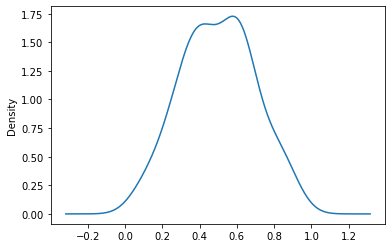

In [20]:
df=pd.read_csv('Immune_pheno_LN_tum_combined.csv')
ax=df[' til_tumor'].plot.kde()
thresh=df[' til_tumor'].median()

for i in range(len(df)):
    if float(df[' til_tumor'][i])>thresh:
        df[' til_tumor'][i]='high'
    else:
        df[' til_tumor'][i]='low' 
df['Immune_ph_comb_til_LN'] = pd.Series(dtype='str')
for i in range(len(df)):
    if df['Immune_ph'][i]=='immune_inflamed':
        df['Immune_ph_comb_til_LN'][i]=df['Immune_ph'][i]+'_'+df[' til_tumor'][i]
    else:
        df['Immune_ph_comb_til_LN'][i]=df['Immune_ph'][i]
print(df.head())

In [21]:
# SURVIVAL ANALYSIS PLOTTING FUNCTIONS: copied from github/lifelines and edited for customization
def is_latex_enabled(): 
    '''
    Returns True if LaTeX is enabled in matplotlib's rcParams,
    False otherwise
    '''
    import matplotlib as mpl

    return mpl.rcParams['text.usetex']


def remove_spines(ax, sides):
    '''
    Remove spines of axis.
    Parameters:
      ax: axes to operate on
      sides: list of sides: top, left, bottom, right
    Examples:
    removespines(ax, ['top'])
    removespines(ax, ['top', 'bottom', 'right', 'left'])
    '''
    for side in sides:
        ax.spines[side].set_visible(False)
    return ax


def move_spines(ax, sides, dists):
    '''
    Move the entire spine relative to the figure.
    Parameters:
      ax: axes to operate on
      sides: list of sides to move. Sides: top, left, bottom, right
      dists: list of float distances to move. Should match sides in length.
    Example:
    move_spines(ax, sides=['left', 'bottom'], dists=[-0.02, 0.1])
    '''
    for side, dist in zip(sides, dists):
        ax.spines[side].set_position(('axes', dist))
    return ax


def remove_ticks(ax, x=False, y=False):
    '''
    Remove ticks from axis.
    Parameters:
      ax: axes to work on
      x: if True, remove xticks. Default False.
      y: if True, remove yticks. Default False.
    Examples:
    removeticks(ax, x=True)
    removeticks(ax, x=True, y=True)
    '''
    if x:
        ax.xaxis.set_ticks_position('none')
    if y:
        ax.yaxis.set_ticks_position('none')
    return ax

def add_at_risk_counts_CUSTOM(*fitters, **kwargs): 
    '''
    Add counts showing how many individuals were at risk at each time point in
    survival/hazard plots.
    Arguments:
      One or several fitters, for example KaplanMeierFitter,
      NelsonAalenFitter, etc...
    Keyword arguments (all optional):
      ax: The axes to add the labels to. Default is the current axes.
      fig: The figure of the axes. Default is the current figure.
      labels: The labels to use for the fitters. Default is whatever was
              specified in the fitters' fit-function. Giving 'None' will
              hide fitter labels.
    Returns:
      ax: The axes which was used.
    Examples:
        # First train some fitters and plot them
        fig = plt.figure()
        ax = plt.subplot(111)
        f1 = KaplanMeierFitter()
        f1.fit(data)
        f1.plot(ax=ax)
        f2 = KaplanMeierFitter()
        f2.fit(data)
        f2.plot(ax=ax)
        # There are equivalent
        add_at_risk_counts(f1, f2)
        add_at_risk_counts(f1, f2, ax=ax, fig=fig)
        # This overrides the labels
        add_at_risk_counts(f1, f2, labels=['fitter one', 'fitter two'])
        # This hides the labels
        add_at_risk_counts(f1, f2, labels=None)
    '''

    # Axes and Figure can't be None
    ax = kwargs.get('ax', None)
    if ax is None:
        ax = plt.gca()

    fig = kwargs.get('fig', None)
    if fig is None:
        fig = plt.gcf()

    fontsize = kwargs.get('fontsize', None)
    if fontsize is None:
        fontsize = 15
        
    if 'labels' not in kwargs:
        labels = [f._label for f in fitters]
        #print(labels)
    else:
        # Allow None, in which case no labels should be used
        labels = kwargs['labels']
        if labels is None:
            labels = [None] * len(fitters)
    # Create another axes where we can put size ticks
    ax2 = plt.twiny(ax=ax)
    # Move the ticks below existing axes
    # Appropriate length scaled for 6 inches. Adjust for figure size.
    ax2_ypos = -0.20 * 6.0 / fig.get_figheight()
    move_spines(ax2, ['bottom'], [ax2_ypos])
    # Hide all fluff
    remove_spines(ax2, ['top', 'right', 'bottom', 'left'])
    # Set ticks and labels on bottom
    ax2.xaxis.tick_bottom()
    # Match tick numbers and locations
    ax2.set_xticks(ax.get_xticks())
    ax2.set_xlim(ax.get_xlim())
    
    # Remove ticks, need to do this AFTER moving the ticks
    remove_ticks(ax2, x=True, y=True)
    # Add population size at times
    ticklabels = []
    for tick in ax2.get_xticks():
        lbl = ""
        for f, l in zip(fitters, labels):
            # First tick is prepended with the label
            #print(f,l)
            if tick == ax2.get_xticks()[0] and l is not None:
                if is_latex_enabled():
                    s = "\n{}\\quad".format(l) + "{}"
                else:
                    s = "\n{}   ".format(l) + "{}"
            else:
                s = "\n{}"
            lbl += s.format(f[f >= tick].shape[0])
        ticklabels.append(lbl.strip())
    # Align labels to the right so numbers can be compared easily
    #print(ticklabels)
    ax2.set_xticklabels(ticklabels, ha='right', fontsize=10)

    # Add a descriptive headline.
    ax2.xaxis.set_label_coords(0, ax2_ypos)
    ax2.set_xlabel('At risk', fontsize=10)

    plt.tight_layout()
    return ax2

In [26]:
def plot_km(col,df,T,C):
    #plt.figure()
    kmf = KaplanMeierFitter()
    ax = plt.subplot(111)
     # Create another axes where we can put size ticks
    fitters=[]
    labels=[]
    df_d=pd.DataFrame()
    df_E=pd.DataFrame()
    G=[]
    
    j=0

    for r in df[col].unique():
        
        ix = df[col] == r
        c=kmf.fit(durations=T[ix], event_observed=C[ix],label=r)
        fitters.append(c.durations)
        df_d=pd.concat([df_d.reset_index(drop=True),T[ix].reset_index(drop=True)],axis=0)
        df_E=pd.concat([df_E.reset_index(drop=True),C[ix].reset_index(drop=True)],axis=0)
        G.append(np.zeros(len(T[ix]))+j)
        
        labels.append(r)
        kmf.plot(ax=ax,ci_show=False, show_censors=True)
        plt.ylim([0,1.2])
        plt.yticks(np.arange(0, 1.2, step=0.2))
        plt.ylabel('Survival probability')
        plt.xlabel('Time in years')
        #plt.legend(bbox_to_anchor=(0, 1.5, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0)
        plt.legend(loc="upper left", mode = "expand", ncol = 3)
        #plt.legend(loc="upper right",frameon=False)
        ax.grid(False)
        j+=1
    d_list=df_d.values.tolist()
    e_list=df_E.values.tolist()
    d_list=np.hstack(d_list)
    e_list=np.hstack(e_list)
    G=np.hstack(G)
    return fitters,labels,ax,d_list,e_list,G

4
['immune_inflamed_high', 'immune_inflamed_low', 'immune_excluded', 'immune_desert']
0.01909320344952062


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           9.94 0.02      5.71

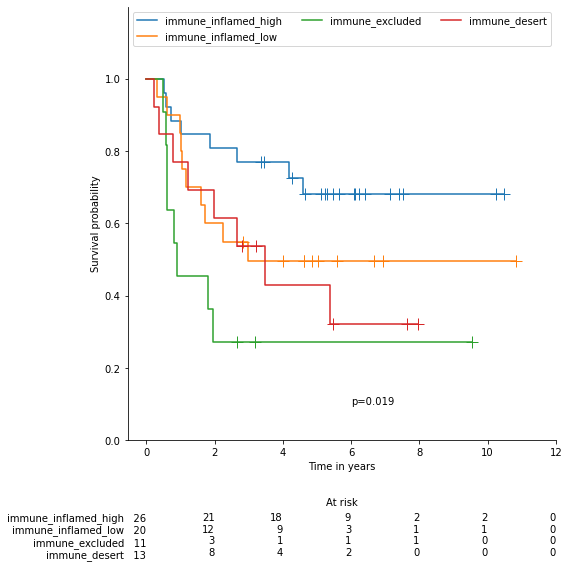

In [29]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test,multivariate_logrank_test
kmf = KaplanMeierFitter()

T=df['Years to Progression or Last Follow-up']
C=df['Case'].astype(float)
col='Immune_ph_comb_til_LN'


plt.figure(figsize=(8, 8))
fitters,labels,ax,d_list,e_list,G=plot_km(col,df,T,C) 
print(len(fitters))
print(labels)

df_rank = pd.DataFrame({
    'durations': d_list,
    'events': e_list,
    'groups': G
})
result = multivariate_logrank_test(df_rank['durations'], df_rank['groups'], df_rank['events'])
result.test_statistic
print(result.p_value)
result.print_summary()

from lifelines.plotting import add_at_risk_counts
import seaborn as sns
sns.despine()
newxticks = []
for x in ax.get_xticks():
    if x >= 0:
        newxticks += [x]

ax.set_xticks(newxticks)
#plt.title('H&N ' + 'TILs LN and tumor immune phenotype ')
plt.text(6,.1,'p={}'.format(round(result.p_value,3),'.3f'))
if len(fitters)==2:
    ax2=add_at_risk_counts_CUSTOM(fitters[0],fitters[1],ax=ax,fontsize=10,labels=labels)
elif len(fitters)==4:
    ax2=add_at_risk_counts_CUSTOM(fitters[0],fitters[1],fitters[2],fitters[3],ax=ax,fontsize=10,labels=labels)

plt.savefig('survival_HN_LN_til_tumor_ph.png')
